In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="train", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [ ]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicyOne = MdpKernel()
mdpPolicyOne.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
mdpPolicyTwo = MdpKernel()
mdpPolicyTwo.load_policy(mdpKernelParams, policyMode="stochastic", randomR=False)

# ==== Prepare Simulator====
num_windows = 5000
obvMode = "predicted" # "perfect" or "predicted"

policySimulator = PolicySimulator(mdpPolicyOne, env)
simResultOne = policySimulator.runSimulation(mdpPolicyOne, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultOne['uRecord'], 
    simResultOne['actionsRecord'], 
    simResultOne['rewardRecord'], 
    simResultOne['uNextRecord']
)

'''
num_windows = 5000
policySimulator = PolicySimulator(mdpPolicyTwo, env)
simResultTwo = policySimulator.runSimulation(mdpPolicyTwo, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")
(uRecord, actionsRecord, rewardRecord, uNextRecord) = (
    simResultOne['uRecord'] + simResultTwo['uRecord'], 
    simResultOne['actionsRecord'] + simResultTwo['actionsRecord'], 
    simResultOne['rewardRecord'] + simResultTwo['rewardRecord'], 
    simResultOne['uNextRecord'] + simResultTwo['uNextRecord']
)
'''

Simulation Progress: 100%|██████████| 5000/5000 [00:09<00:00, 512.22it/s, avg reward=0.003949]


'\nnum_windows = 5000\npolicySimulator = PolicySimulator(mdpPolicyTwo, env)\nsimResultTwo = policySimulator.runSimulation(mdpPolicyTwo, num_windows=num_windows, obvMode=obvMode, mode="train", type="data")\n(uRecord, actionsRecord, rewardRecord, uNextRecord) = (\n    simResultOne[\'uRecord\'] + simResultTwo[\'uRecord\'], \n    simResultOne[\'actionsRecord\'] + simResultTwo[\'actionsRecord\'], \n    simResultOne[\'rewardRecord\'] + simResultTwo[\'rewardRecord\'], \n    simResultOne[\'uNextRecord\'] + simResultTwo[\'uNextRecord\']\n)\n'

In [4]:
diffusionQParams = {
    'device': 'cuda',
    'gamma': 0.1,
    'tau': 0.005,
    'lr': 5e-3,
    'eta': 1.0,
    'iql_tau': 0.95,
    'temperature': 3.0,
    'N_action_candidates': 50
}
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict, info = diffusionPolicyInterface.train(
    (uRecord, actionsRecord, rewardRecord, uNextRecord), 
    env, iql_flag=True, epochs=500,batch_size=1024, sample_method="greedy")

Evaluation windows: 100%|██████████| 500/500 [00:16<00:00, 30.80it/s]                                                             


Epoch   50/ 500  Avg Ld=0.313938  Avg Lq=40.825359  Avg loss_critic=0.020211  Test packet loss=0.0357  Avg Q_value_check=0.054753


Evaluation windows: 100%|██████████| 500/500 [00:17<00:00, 28.63it/s]                                                            


Epoch  100/ 500  Avg Ld=0.112948  Avg Lq=1.911870  Avg loss_critic=0.000063  Test packet loss=0.0190  Avg Q_value_check=0.072860


Evaluation windows: 100%|██████████| 500/500 [00:18<00:00, 26.39it/s]                                                             


Epoch  150/ 500  Avg Ld=0.092674  Avg Lq=1.166064  Avg loss_critic=0.000192  Test packet loss=0.0094  Avg Q_value_check=0.096726


Evaluation windows: 100%|██████████| 500/500 [00:16<00:00, 29.98it/s]                                                             


Epoch  200/ 500  Avg Ld=0.080431  Avg Lq=0.975244  Avg loss_critic=0.000049  Test packet loss=0.0102  Avg Q_value_check=0.104375


Evaluation windows: 100%|██████████| 500/500 [00:22<00:00, 22.58it/s]                                                             


Epoch  250/ 500  Avg Ld=0.073278  Avg Lq=0.907960  Avg loss_critic=0.000048  Test packet loss=0.0091  Avg Q_value_check=0.108041


Evaluation windows: 100%|██████████| 500/500 [00:16<00:00, 29.89it/s]                                                             


Epoch  300/ 500  Avg Ld=0.066263  Avg Lq=0.798779  Avg loss_critic=0.000047  Test packet loss=0.0082  Avg Q_value_check=0.109488


Evaluation windows: 100%|██████████| 500/500 [00:15<00:00, 31.64it/s]                                                             


Epoch  350/ 500  Avg Ld=0.062783  Avg Lq=0.735742  Avg loss_critic=0.000047  Test packet loss=0.0068  Avg Q_value_check=0.110040


Evaluation windows: 100%|██████████| 500/500 [00:27<00:00, 18.28it/s]                                                             


Epoch  400/ 500  Avg Ld=0.057587  Avg Lq=0.728225  Avg loss_critic=0.000047  Test packet loss=0.0071  Avg Q_value_check=0.110215


Evaluation windows: 100%|██████████| 500/500 [00:16<00:00, 30.04it/s]                                                             


Epoch  450/ 500  Avg Ld=0.054469  Avg Lq=0.695060  Avg loss_critic=0.000047  Test packet loss=0.0055  Avg Q_value_check=0.110216


Evaluation windows: 100%|██████████| 500/500 [01:05<00:00,  7.68it/s]                                                             

Epoch  500/ 500  Avg Ld=0.048813  Avg Lq=0.678305  Avg loss_critic=0.000047  Test packet loss=0.0054  Avg Q_value_check=0.110098


In [5]:
# Save the trained model state dictionary
import torch
torch.save(model_state_dict, f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
print(f"Model saved to Results/DiffusionQ/diffusionQ_config{configIdx}.pth")
with open(f'Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(info, f)
print(f"Info saved to Results/DiffusionQ/diffusionQ_info_config{configIdx}.pkl")
with open(f'Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl', 'wb') as f:
    pickle.dump(diffusionQParams, f)
print(f"Params saved to Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl")

Model saved to Results/DiffusionQ/diffusionQ_config0.pth
Info saved to Results/DiffusionQ/diffusionQ_info_config0.pkl
Params saved to Results/DiffusionQ/diffusionQ_params_config0.pkl


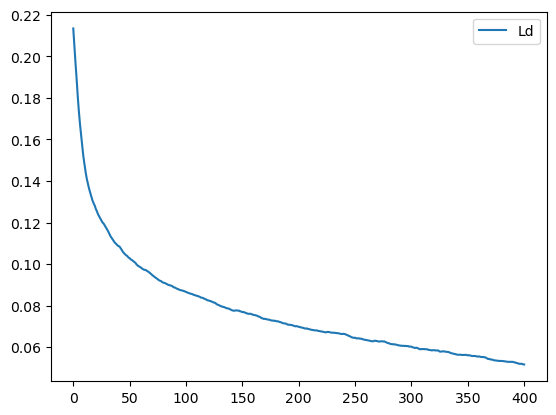

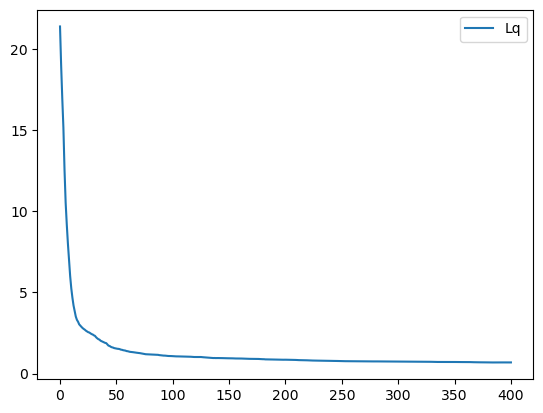

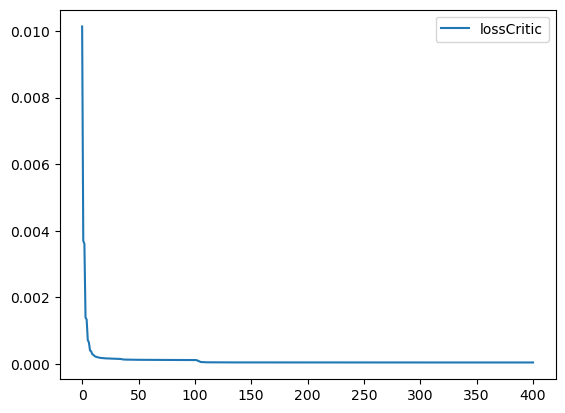

In [6]:
def smooth(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

obv_idxs = -1000
window_size = 100
plt.plot(smooth(info['LdRecord'][obv_idxs:], window_size=window_size), label="Ld")
plt.legend()
plt.show()
plt.plot(smooth(info['LqRecord'][obv_idxs:], window_size=window_size), label="Lq")
plt.legend()
plt.show()
plt.plot(smooth(info['lossCriticRecord'][obv_idxs:], window_size=window_size), label="lossCritic")
plt.legend()
plt.show()